This tutorial shows how to use the package to create an approximated Bayesian estimate of a DCC and a stochastic volatility model, running the inference throw example data.
The required packages are:

In [7]:
###IMPORTS
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from wrappers import VIwrapper_JumpsOUdiff

Examples data are available in the package folder.
Read it with:

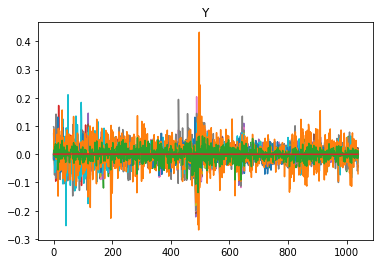

In [8]:
#data import and plot
path_csv=r'./MultiAsset ptf - returns.csv'
y_df=pd.read_csv(path_csv,header=0,index_col=0)
y=np.float32(y_df.values)
T,N=y.shape
plt.plot(y)
plt.title('Y')
plt.show()

First of all, let's instatiate the model and the reparametrization of the set of solutions using:

In [3]:
MC=64
#this command clears the computational graph of tf
tf.reset_default_graph()
#the train_epochs_limit_min and max equal are used to force the number of steps of the training process
epochs_num=200
OUdiff=VIwrapper_JumpsOUdiff('OUdiffusion',y[:-1],MC,jumps=False,train_epochs_limit_max=epochs_num,train_epochs_limit_min=epochs_num)

This operations has just initialized the variables and the tensors that will be used to estimate. To effectively run the inference we need to create a tensorflow session and then run the wrapper's function. Let's do it, and let's save a samples from the approximated posterior of the cholesky decomposition of the vcv

In [4]:
init = tf.global_variables_initializer()        
with tf.Session() as sess:
    sess.run(init)
    elbo,train_llkl,_=OUdiff.run_inference(sess,diagnostic=True)
    perf=OUdiff.get_logPy(y[-1:],sess,MC*2)
    cholVcv_samples=sess.run(OUdiff.sampler.states['cholVcv'])

train round: -1
step time: 30.357204914093018
Entropies:
cholVcv -3102865.5, OU mu -1722.328125, W -259185.375, OU rate -2.229949951171875
Null mean
train round: 0
step time: 17.97530484199524
Entropies:
cholVcv -3102861.75, OU mu -1722.3359375, W -259183.0, OU rate -2.2299728393554688
Null mean


At every minimum of the elbo entropies are plotted, showing which parameters variances are inflated and which are reduced.
Then we can, for example, plot the trace-plot of the elbo, to see how went the convergence of the optimization, and plot the particles of the volatility of the first title.

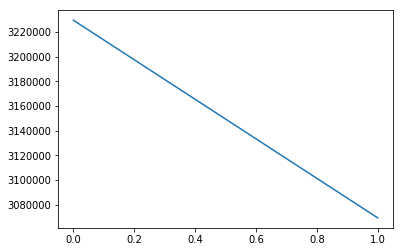

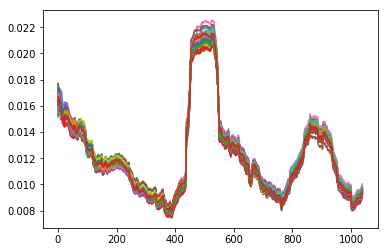

In [6]:
plt.plot(elbo)
plt.show()
#the cholVcv_samples will have dimensions MC,T,N,N
vcv_samples=cholVcv_samples@cholVcv_samples.transpose([0,1,3,2])
plt.plot(np.sqrt(vcv_samples[:,:,0,0].transpose([1,0])))
plt.show()